In [104]:
import pandas as pd

def load_data():
    data = {
        "normal": {
            "assault_double": pd.read_csv(
                "../best_training_32K/assault/assault_double_training_history.csv"
            ),
            "assault_rainbow": pd.read_csv(
                "../best_training_32K/assault/assault_rainbow_training_history.csv"
            ),
            "breakout_double": pd.read_csv(
                "../best_training_32K/breakout/breakout_double_training_history.csv"
            ),
            "breakout_rainbow": pd.read_csv(
                "../best_training_32K/breakout/breakout_rainbow_training_history.csv"
            ),
        },
        "10k": {
            "assault_double": pd.read_csv(
                "../best_training_10K/assault/assault_double_training_history.csv"
            ),
            "assault_rainbow": pd.read_csv(
                "../best_training_10K/assault/assault_rainbow_training_history.csv"
            ),
            "breakout_double": pd.read_csv(
                "../best_training_10K/breakout/breakout_double_training_history.csv"
            ),
            "breakout_rainbow": pd.read_csv(
                "../best_training_10K/breakout/breakout_rainbow_training_history.csv"
            ),
        },
        "random": {
            "assault": pd.read_csv(
                "../1_life_training/random/test_random_assault_results.csv"
            ),
            "breakout": pd.read_csv(
                "../1_life_training/random/test_random_breakout_results.csv"
            ),
        },
    }
    return data


In [105]:
def better_spines(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(True)

In [106]:
import matplotlib.pyplot as plt

REPLAY_START_SIZE = 80_000  # Size of replay memory before starting training

data = load_data()

window_size = 50

def calculate_moving_averages(df, window_size):
    df["episode_rewards_ma"] = df["episode_rewards"].rolling(window=window_size).mean()
    df["episode_rewards_min"] = df["episode_rewards"].rolling(window=window_size).min()
    df["episode_rewards_max"] = df["episode_rewards"].rolling(window=window_size).max()
    if "loss" in df:
        df["loss_ma"] = df["loss"].rolling(window=window_size).mean()
        df["loss_min"] = df["loss"].rolling(window=window_size).min()
        df["loss_max"] = df["loss"].rolling(window=window_size).max()
        df["mean_q_value_ma"] = df["mean_q_value"].rolling(window=window_size).mean()
        df["mean_q_value_min"] = df["mean_q_value"].rolling(window=window_size).min()
        df["mean_q_value_max"] = df["mean_q_value"].rolling(window=window_size).max()

# Apply the function to each DataFrame
for key in data["normal"]:
    calculate_moving_averages(data["normal"][key], window_size)
    calculate_moving_averages(data["10k"][key], window_size)

def plot_dict(axes, column, title, plot_infos_32k, plot_infos_10k, REPLAY_START_SIZE):
    # Plot smoothed total rewards for 32k
    axes[0, column].plot(
        plot_infos_32k["steps"][: len(plot_infos_32k["episode_rewards_ma"])],
        plot_infos_32k["episode_rewards_ma"],
        label="32K Target Network Update",
        color="C2",
    )
    axes[0, column].fill_between(
        plot_infos_32k["steps"][: len(plot_infos_32k["episode_rewards_ma"])],
        plot_infos_32k["episode_rewards_min"],
        plot_infos_32k["episode_rewards_max"],
        color="C2",
        alpha=0.1,
    )

    # Plot smoothed total rewards for 10k
    axes[0, column].plot(
        plot_infos_10k["steps"][: len(plot_infos_10k["episode_rewards_ma"])],
        plot_infos_10k["episode_rewards_ma"],
        label="10K Target Network Update",
        color="C3",
    )
    axes[0, column].fill_between(
        plot_infos_10k["steps"][: len(plot_infos_10k["episode_rewards_ma"])],
        plot_infos_10k["episode_rewards_min"],
        plot_infos_10k["episode_rewards_max"],
        color="C3",
        alpha=0.1,
    )

    axes[0, column].set_ylabel("Total Reward")
    axes[0, column].set_xlabel("Steps")
    axes[0, column].grid(True)
    axes[0, column].axvline(REPLAY_START_SIZE, color="gray", linestyle="--", label="Replay Start Size")
    axes[0, column].legend(loc="upper left", borderaxespad=1.0).set_zorder(2)
    better_spines(axes[0, column])

    # Plot mean Q value
    axes[1, column].plot(
        plot_infos_32k["steps"][: len(plot_infos_32k["mean_q_value_ma"])],
        plot_infos_32k["mean_q_value_ma"],
        label="32K Target Network Update",
        color="C2",
    )
    axes[1, column].fill_between(
        plot_infos_32k["steps"][: len(plot_infos_32k["mean_q_value_ma"])],
        plot_infos_32k["mean_q_value_min"],
        plot_infos_32k["mean_q_value_max"],
        color="C2",
        alpha=0.1,
    )

    axes[1, column].plot(
        plot_infos_10k["steps"][: len(plot_infos_10k["mean_q_value_ma"])],
        plot_infos_10k["mean_q_value_ma"],
        label="10K Target Network Update",
        color="C3",
    )
    axes[1, column].fill_between(
        plot_infos_10k["steps"][: len(plot_infos_10k["mean_q_value_ma"])],
        plot_infos_10k["mean_q_value_min"],
        plot_infos_10k["mean_q_value_max"],
        color="C3",
        alpha=0.1,
    )

    axes[1, column].set_ylabel("Mean Q Value")
    axes[1, column].set_xlabel("Steps")
    axes[1, column].grid(True)
    axes[1, column].axvline(REPLAY_START_SIZE, color="gray", linestyle="--", label="Replay Start Size")
    better_spines(axes[1, column])

    # Plot loss
    axes[2, column].plot(
        plot_infos_32k["steps"][: len(plot_infos_32k["loss_ma"])],
        plot_infos_32k["loss_ma"],
        label="32K Target Network Update",
        color="C2",
    )
    axes[2, column].fill_between(
        plot_infos_32k["steps"][: len(plot_infos_32k["loss_ma"])],
        plot_infos_32k["loss_min"],
        plot_infos_32k["loss_max"],
        color="C2",
        alpha=0.1,
    )

    axes[2, column].plot(
        plot_infos_10k["steps"][: len(plot_infos_10k["loss_ma"])],
        plot_infos_10k["loss_ma"],
        label="10K Target Network Update",
        color="C3",
    )
    axes[2, column].fill_between(
        plot_infos_10k["steps"][: len(plot_infos_10k["loss_ma"])],
        plot_infos_10k["loss_min"],
        plot_infos_10k["loss_max"],
        color="C3",
        alpha=0.1,
    )

    axes[2, column].set_ylabel("Loss")
    axes[2, column].set_xlabel("Steps")
    axes[2, column].grid(True)
    axes[2, column].axvline(REPLAY_START_SIZE, color="gray", linestyle="--", label="Replay Start Size")
    better_spines(axes[2, column])
    
    # set title
    axes[0, column].set_title(title, y=1.02)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(30, 15), dpi=200)

# Convert the DataFrame back to a dictionary
for i, key in enumerate(data["normal"]):
    pi_32k = data["normal"][key].to_dict(orient="list")
    pi_10k = data["10k"][key].to_dict(orient="list")
    plot_dict(axes, i, f"{key.replace('_', ' ').title()} Training (MA-50)", pi_32k, pi_10k, REPLAY_START_SIZE)

fig.tight_layout()
plt.title("Training History")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../best_training_32K/assault/assault_double_training_history.csv'

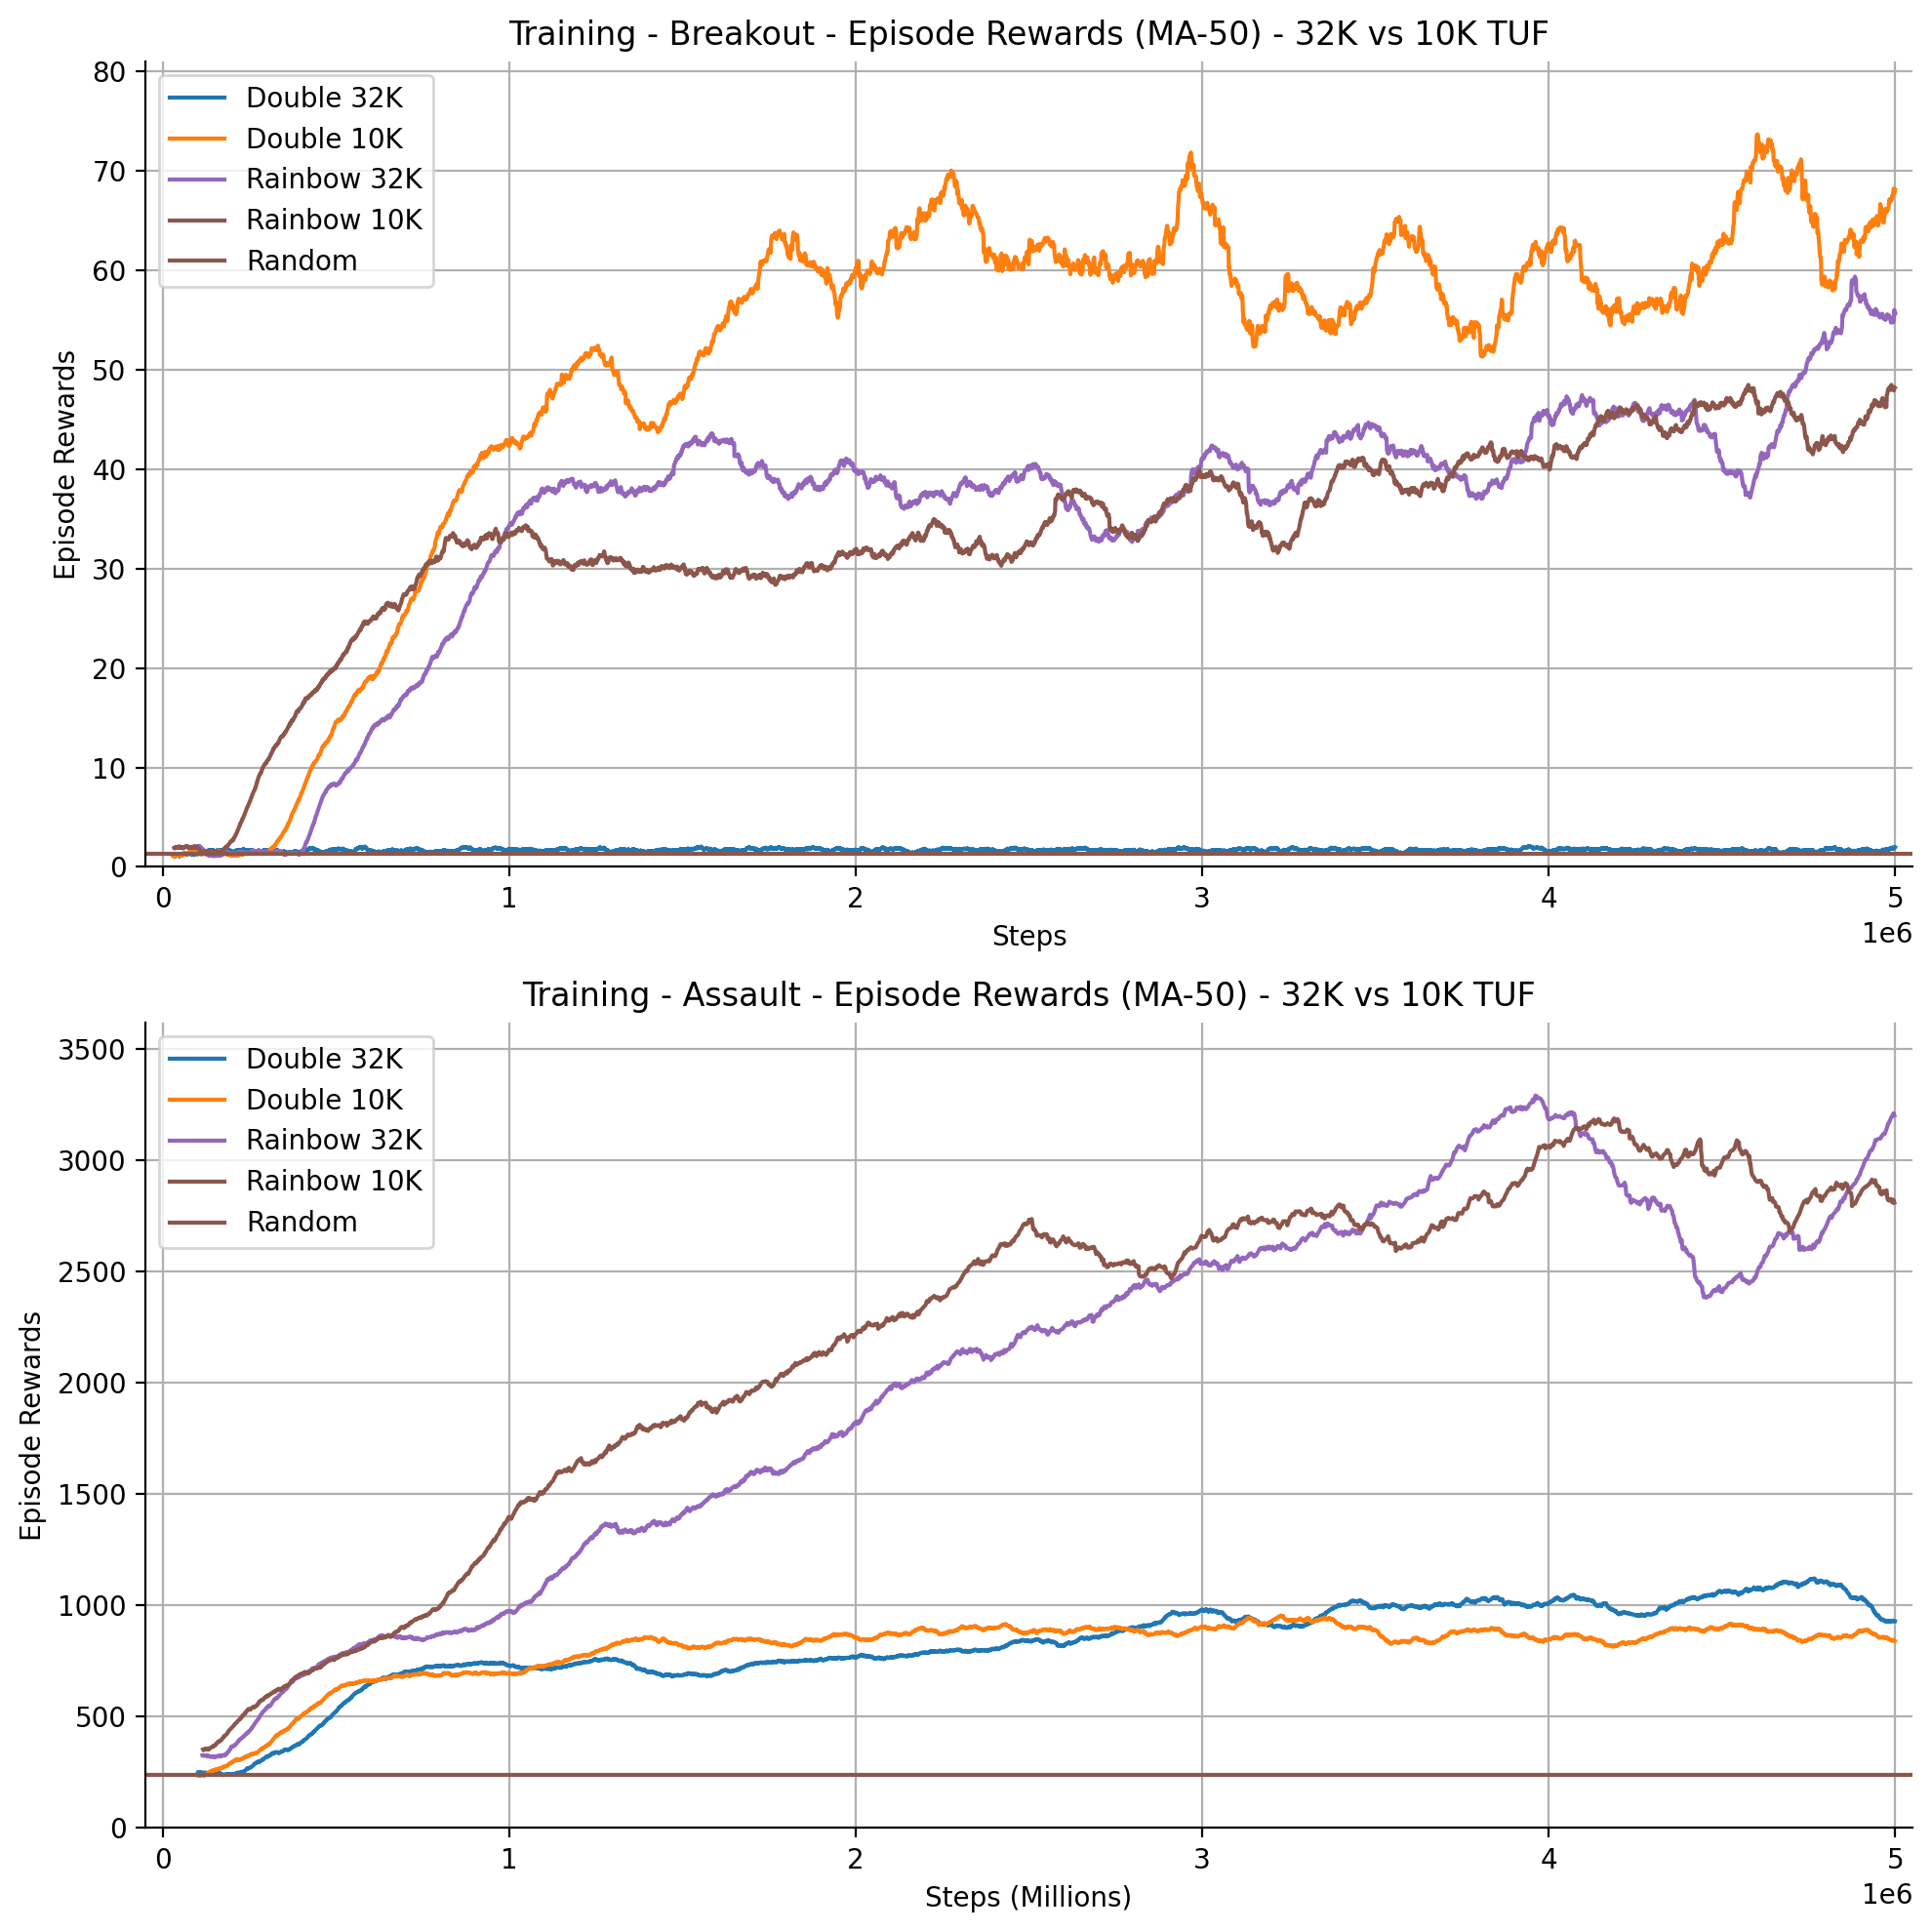

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_episode_rewards_moving_averages(df, window_size):
    df["episode_rewards_ma"] = df["episode_rewards"].rolling(window=window_size).mean()
    df["episode_rewards_min"] = df["episode_rewards"].rolling(window=window_size).min()
    df["episode_rewards_max"] = df["episode_rewards"].rolling(window=window_size).max()

def apply_moving_averages(data, window_size):
    for key in data:
        for df in data[key].values():
            if "episode_rewards" in df:
                calculate_episode_rewards_moving_averages(df, window_size)

def calculate_random_baselines(df_random):
    random_mean = df_random["mean_reward"].mean()
    random_min = df_random["min_reward"].mean()
    random_max = df_random["max_reward"].mean()
    return random_mean, random_min, random_max

def plot_data(
    axes,
    datasets,
    random_mean,
    random_min,
    random_max,
    title,
    xlabel,
    ylabel,
    colors,
    labels
):
    for df, color, label in zip(datasets, colors, labels):
        axes.plot(
            df["steps"],
            df["episode_rewards_ma"],
            label=label,
            color=color,
        )

    axes.axhline(y=random_mean, color="C5", linestyle="-", label="Random")

    axes.set_xlim([-50_000, 5_050_000])
    axes.set_ylim(
        [
            0,
            max(
                max(df["episode_rewards_ma"].max() for df in datasets),
                random_max,
            )
            * 1.1,
        ]
    )

    axes.set_title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.legend()
    axes.grid(True)
    better_spines(axes)

window_size = int(50 / 15 * 50)
apply_moving_averages(data, window_size)

breakout_random_mean, breakout_random_min, breakout_random_max = (
    calculate_random_baselines(data["random"]["breakout"])
)
assault_random_mean, assault_random_min, assault_random_max = (
    calculate_random_baselines(data["random"]["assault"])
)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=200)

# Plot Breakout data
plot_data(
    axes[0],
    [
        data["normal"]["breakout_double"],
        data["10k"]["breakout_double"],
        data["normal"]["breakout_rainbow"],
        data["10k"]["breakout_rainbow"],
    ],
    breakout_random_mean,
    breakout_random_min,
    breakout_random_max,
    "Training - Breakout - Episode Rewards (MA-50) - 32K vs 10K TUF",
    "Steps",
    "Episode Rewards",
    ["C0", "C1", "C4", "C5"],
    ["Double 32K", "Double 10K", "Rainbow 32K", "Rainbow 10K"]
)

# Plot Assault data
plot_data(
    axes[1],
    [
        data["normal"]["assault_double"],
        data["10k"]["assault_double"],
        data["normal"]["assault_rainbow"],
        data["10k"]["assault_rainbow"],
    ],
    assault_random_mean,
    assault_random_min,
    assault_random_max,
    "Training - Assault - Episode Rewards (MA-50) - 32K vs 10K TUF",
    "Steps (Millions)",
    "Episode Rewards",
    ["C0", "C1", "C4", "C5"],
    ["Double 32K", "Double 10K", "Rainbow 32K", "Rainbow 10K"]
)

plt.tight_layout()
plt.show()


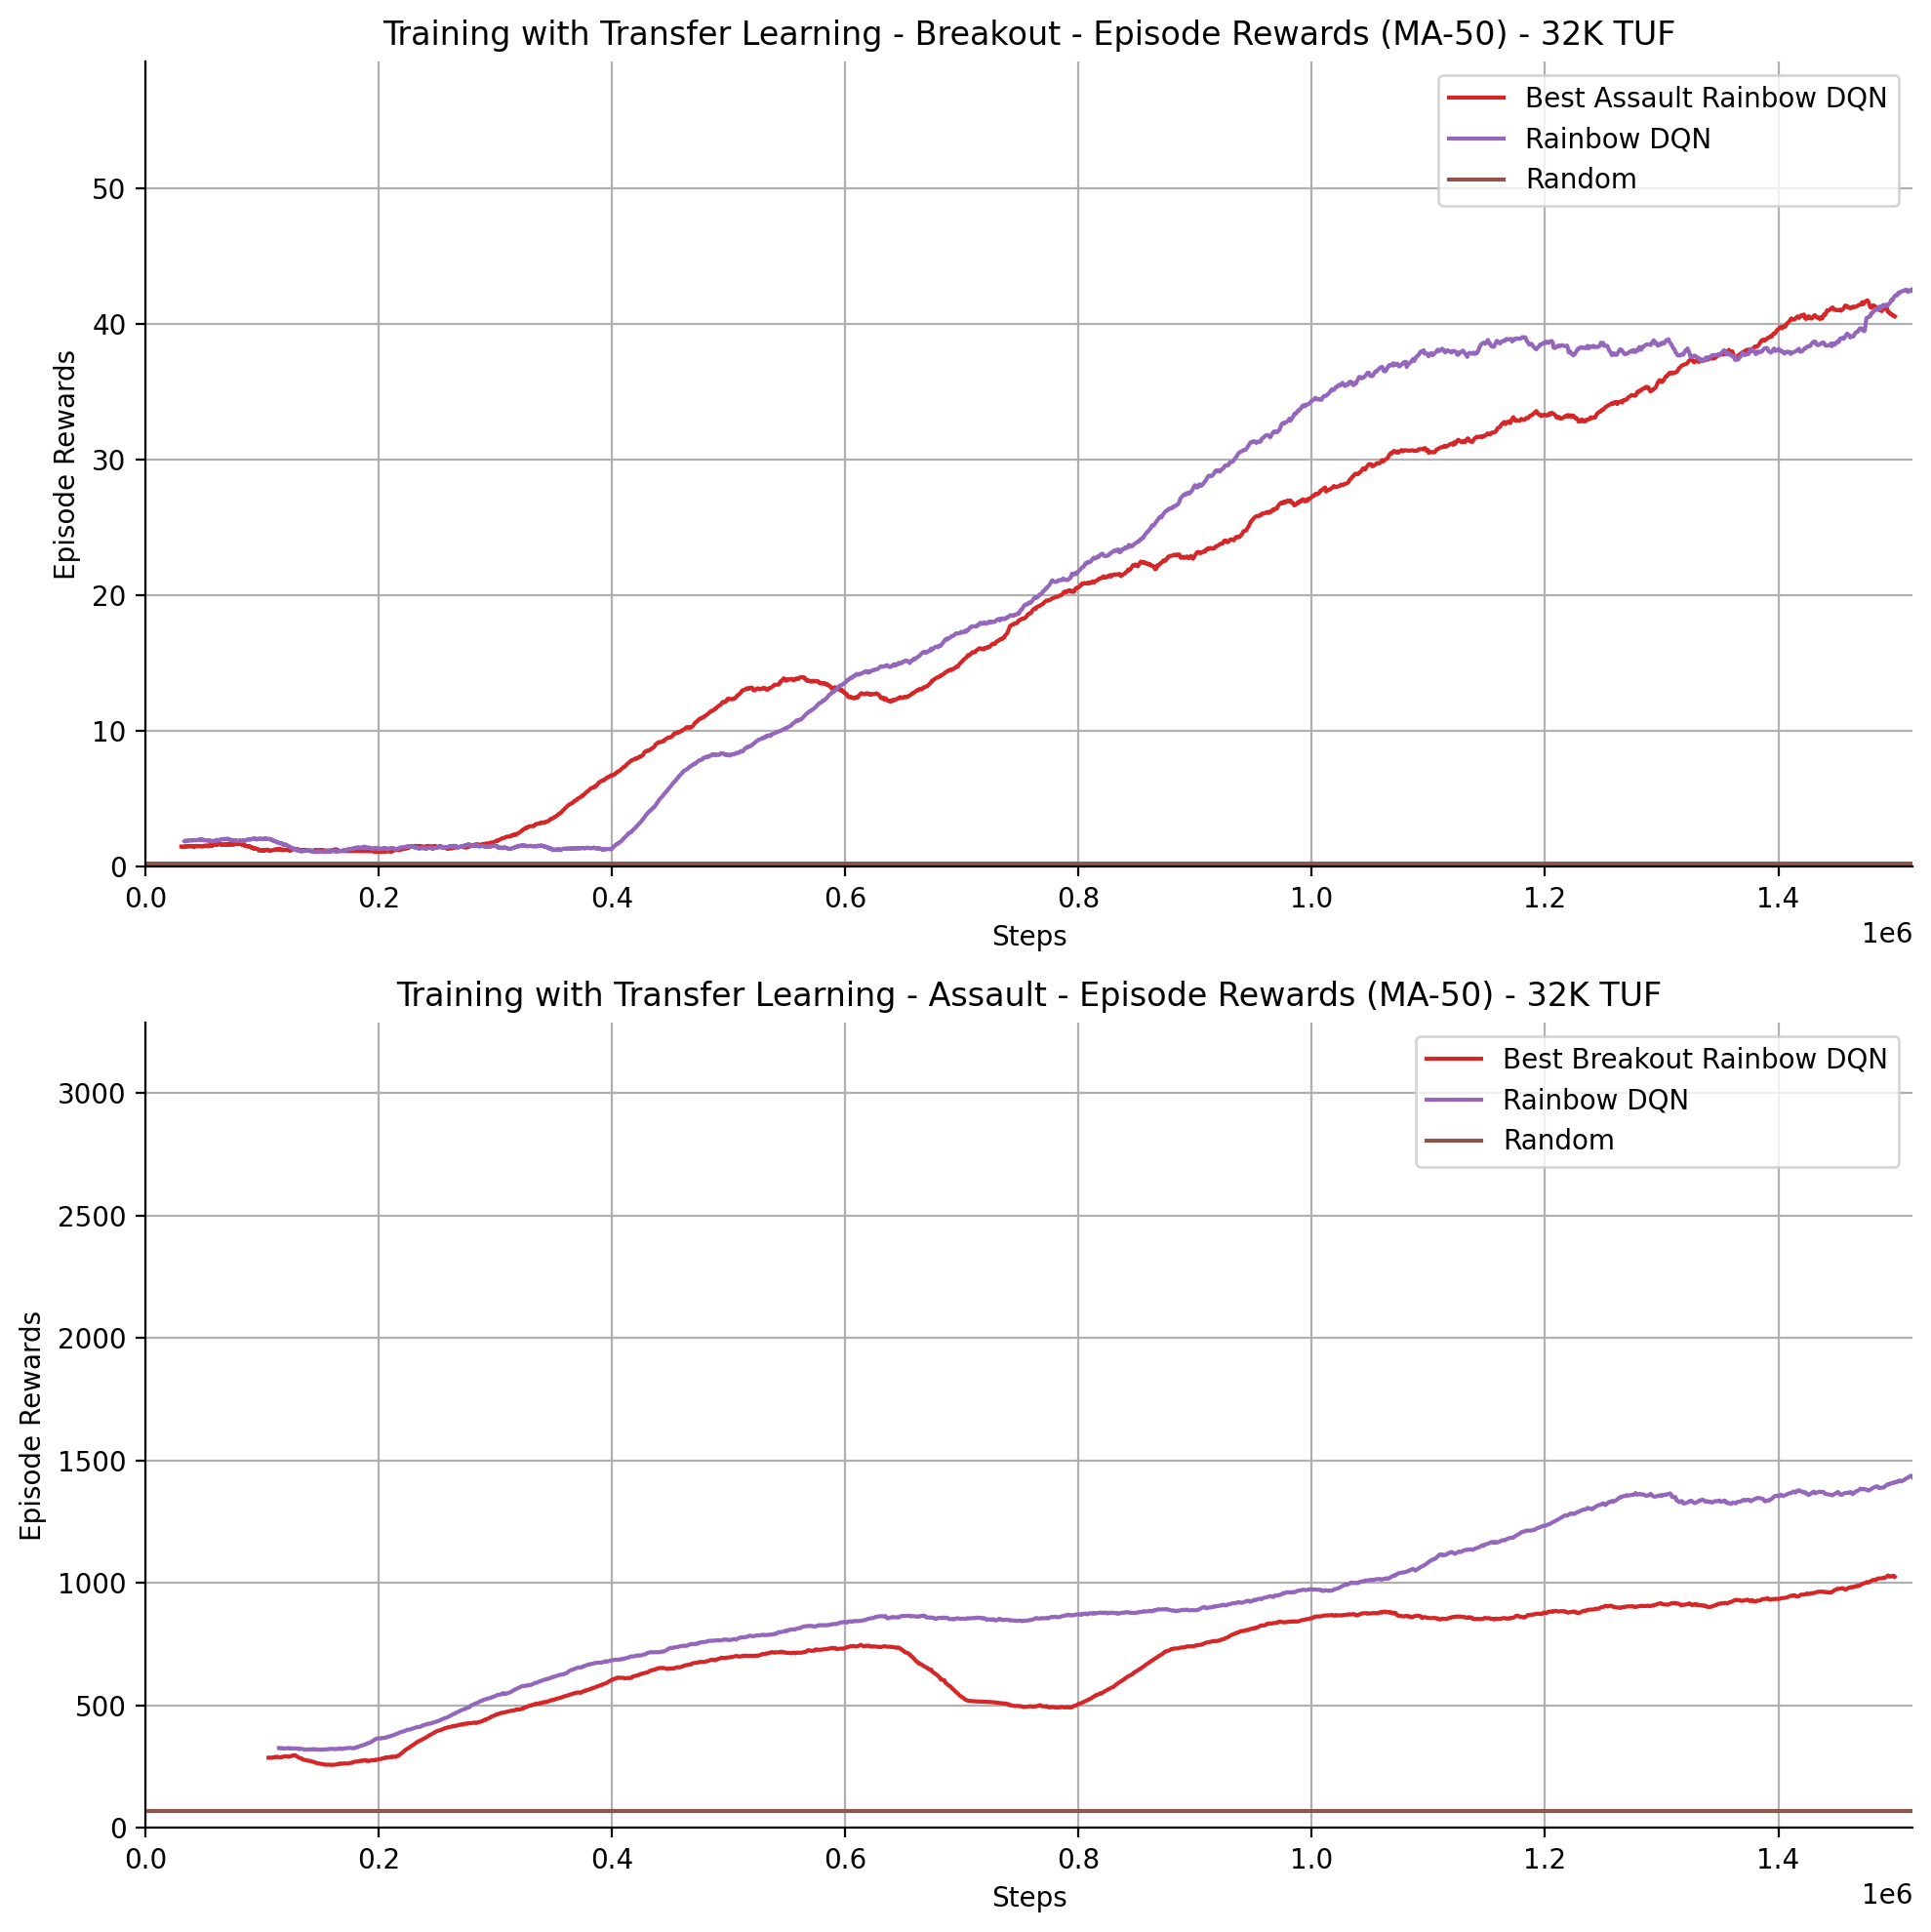

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

df_a_b_rainbow = pd.read_csv(
    "../best_training_32K/a=>b rb/breakout_rainbow_training_history.csv"
)
df_b_a_rainbow = pd.read_csv(
    "../best_training_32K/b=>a rb/assault_rainbow_training_history.csv"
)

# a stands for Assault and b stands for Breakout
df_assault_rainbow = pd.read_csv(
    "../best_training_32K/assault/assault_rainbow_training_history.csv"
)
df_breakout_rainbow = pd.read_csv(
    "../best_training_32K/breakout/breakout_rainbow_training_history.csv"
)

# Random baselines
df_breakout_random = pd.read_csv(
    "../1_life_training/random/test_random_1l_breakout_rainbow_results.csv"
)
df_assault_random = pd.read_csv(
    "../1_life_training/random/test_random_1l_assault_rainbow_results.csv"
)

window_size = int(50 / 15 * 50)


# Apply the function to each DataFrame
calculate_episode_rewards_moving_averages(df_a_b_rainbow, window_size)
calculate_episode_rewards_moving_averages(df_b_a_rainbow, window_size)
calculate_episode_rewards_moving_averages(df_assault_rainbow, window_size)
calculate_episode_rewards_moving_averages(df_breakout_rainbow, window_size)

# Calculate mean, min, and max for random baselines
breakout_random_mean = df_breakout_random["mean_reward"].mean()
breakout_random_min = df_breakout_random["min_reward"].mean()
breakout_random_max = df_breakout_random["max_reward"].mean()

assault_random_mean = df_assault_random["mean_reward"].mean()
assault_random_min = df_assault_random["min_reward"].mean()
assault_random_max = df_assault_random["max_reward"].mean()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), dpi=200)


axes[0].plot(
    df_a_b_rainbow["steps"],
    df_a_b_rainbow["episode_rewards_ma"],
    label="Best Assault Rainbow DQN",
    color="C3",
)

axes[0].plot(
    df_breakout_rainbow["steps"],
    df_breakout_rainbow["episode_rewards_ma"],
    label="Rainbow DQN",
    color="C4",
)

# Plot horizontal line and filler for Breakout Random
axes[0].axhline(y=breakout_random_mean, color="C5", linestyle="-", label="Random")

axes[0].set_xlim([0, 1_515_000])
axes[0].set_ylim(
    [
        0,
        max(
            df_a_b_rainbow["episode_rewards_ma"].max(),
            df_breakout_rainbow["episode_rewards_ma"].max(),
            breakout_random_max,
        ),
    ]
)

axes[0].set_title(
    "Training with Transfer Learning - Breakout - Episode Rewards (MA-50) - 32K TUF"
)
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("Episode Rewards")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(
    df_b_a_rainbow["steps"],
    df_b_a_rainbow["episode_rewards_ma"],
    label="Best Breakout Rainbow DQN",
    color="C3",
)

axes[1].plot(
    df_assault_rainbow["steps"],
    df_assault_rainbow["episode_rewards_ma"],
    label="Rainbow DQN",
    color="C4",
)

# Plot horizontal line and filler for Assault Random
axes[1].axhline(y=assault_random_mean, color="C5", linestyle="-", label="Random")

axes[1].set_xlim([0, 1_515_000])
axes[1].set_ylim(
    [
        0,
        max(
            df_b_a_rainbow["episode_rewards_ma"].max(),
            df_assault_rainbow["episode_rewards_ma"].max(),
            assault_random_max,
        ),
    ]
)

axes[1].set_title("Training with Transfer Learning - Assault - Episode Rewards (MA-50) - 32K TUF")
axes[1].set_xlabel("Steps")
axes[1].set_ylabel("Episode Rewards")
axes[1].legend()
axes[1].grid(True)
better_spines(axes[0])
better_spines(axes[1])

plt.tight_layout()
plt.show()
